In [1803]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import copy

from networkx.algorithms import community

warnings.simplefilter('ignore')

In [1804]:
def readNet(filename):
    net = {}

    with open(filename, "r") as file:
        n = int(file.readline())
        net['noNoes'] = n

        mat = []
        degrees = []
        noEdges = 0
        for i in range(n):
            mat.append([])
            line = file.readline()
            elems = line.split(" ")

            degree = 0
            for j in range(n):    
                el = int(elems[j])
                if el == 1:
                    degree += 1
                if j > i:
                    noEdges += el 
                    
                mat[-1].append(el)
            
            degrees.append(degree)

    net["mat"] = mat
    net["noEdges"] = noEdges
    net["degrees"] = degrees

    return net

In [1805]:
"""
    Metoda care citeste un graf dintr-un fisier de tip gml
    @params: filename - path catre un fisier gml
    @return: Graph - un obiect de tip Graph
"""
def readGraph(filename):
    graph = nx.read_gml(os.path.join(os.getcwd(), 'data', 'dolphins', 'dolphins.gml'))

    return graph

In [1806]:
def readCommunityClasses(filename):
    classes = []

    with open(filename, "r") as file:
        for line in file:
            classes.append(int(line.split(" ")[-1]))
    
    return classes

In [1807]:
"""
def plotNetwork(network, communities = [[1, 1, 1, 1, 1, 1]]):
    np.random.seed(42)

    A = np.matrix(network["mat"])
    G = nx.from_numpy_matrix(A) # returneaza un graf pe baza unei matrici (de adiacenta)
    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)
    
    plt.figure(figsize = (4, 4))
    nx.draw_networkx_nodes(G, pos, node_size = 600, cmap = plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy
    plt.show(G)
"""

'\ndef plotNetwork(network, communities = [[1, 1, 1, 1, 1, 1]]):\n    np.random.seed(42)\n\n    A = np.matrix(network["mat"])\n    G = nx.from_numpy_matrix(A) # returneaza un graf pe baza unei matrici (de adiacenta)\n    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)\n    \n    plt.figure(figsize = (4, 4))\n    nx.draw_networkx_nodes(G, pos, node_size = 600, cmap = plt.cm.RdYlBu, node_color = communities)\n    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy\n    plt.show(G)\n'

In [1808]:
def plotNetwork(G, communities = [[1, 1, 1, 1, 1, 1]], node_size = 50):
    np.random.seed(42)

    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)
    
    plt.figure(figsize = (5, 5))
    nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy
    nx.draw_networkx_labels(G, pos) # alpha = edge transparancy
    plt.show(G)

In [1809]:
"""
crtDir = os.getcwd()
filePath = os.path.join(crtDir, 'data', 'net.in')
network = readNet(filePath)

plotNetwork(network)
"""

"\ncrtDir = os.getcwd()\nfilePath = os.path.join(crtDir, 'data', 'net.in')\nnetwork = readNet(filePath)\n\nplotNetwork(network)\n"

In [1810]:
#mockCommunities = [1, 2, 1, 2, 1, 1]
#plotNetwork(network, mockCommunities)

In [1811]:
class DetectingCommunities:
    
    """
        Date de intrare: graful aferent sau fisierul gml in care se afla graful
        Date de iesire: un vector care precizeaza pentru fiecare nod in ce comunitate se afla
    """
    def __init__(self, graph = None, input_file = None):
        if graph == None and input_file == None:
            raise Exception("None attributes")

        if graph == None:
            self.__graph = nx.read_gml(input_file)
        else:
            self.__graph = graph
        
        self.__communities = dict([(i, [i]) for i in self.__graph.nodes])
        self.__forest = dict(zip(self.__graph.nodes, self.__graph.nodes))
        self.__result = self.__communities

        self.__e = dict()
        for node in self.__graph.nodes:
            self.__e[node] = dict()
            self.__e[node][node] = 0
            for ngh in self.__graph.neighbors(node):
                self.__e[node][ngh] = self.__graph.number_of_edges(node, ngh) / self.__graph.number_of_edges()

        suma = 0
        for node1 in self.__e.keys():
            for node2 in self.__e[node1].keys():
                suma += self.__e[node1][node2]

        #self.__a = dict(zip(self.__graph.nodes, [sum([x for _, x in self.__e[i].items()]) for i in self.__e.keys()])) 
        self.__updateA()

        assert(len(self.__e) == len(self.__a))

        self.__q = sum([self.__e[x][x] - self.__a[x] * self.__a[x] for x in self.__e])
        self.__maxq = self.__q

    """
        Metoda care da update la lista a
        @params: -
        @return: -
    """
    def __updateA(self):
        self.__a = dict(zip(list(self.__communities.keys()), [sum([x for _, x in self.__e[i].items()]) for i in self.__communities.keys()])) 
    
    """
        Metoda care returneaza comunitatile vecine unei comunitati date
        @params: community - int care identifica comunitatea pentru care se doreste sa se afle comunitatile vecine
        @return: un array care contine numerele ce identifica comunitatile vecine
    """
    def __getCommunityNeighbours(self, community):
        neighbours = []
        for x in list(self.__communities[community]):
            neighbours.extend(list(self.__e[self.__find(x)].keys()))
        return set(neighbours)

    """
        Metoda care gaseste radacina comunitatii din care face parte un nod 
        @params: node - nodul pentru care se doreste gasirea radacinii comunitatii din care face parte (si a comunitatii implicit) 
        @return: int - id-ul comunitatii din care face parte
        @exceptii: "Nod invalid!" daca valoare nodului este mai mare decat numarul de noduri din graf
    """
    def __find(self, node):
        if node < 0:
            raise Exception("Nod invalid!")

        if self.__forest[node] == node:
            return node 
        result = self.__find(self.__forest[node])
        self.__forest[node] = result
        return result

    """
        Leaga doua comunitati intre ele
        @params: community1 - id-ul primei comunitati de legat
                 community2 - id-ul celei de a doua comunitati de legat
        @return: -
        @exceptii: "Comunitate invalida!" daca community1 sau community2 mai mare decat numarul de comunitati
    """
    def __uniteCommunities(self, community1, community2):
        if community1 < 0 or community2 < 0:
            raise Exception("Comunitate invalida!")

        fatherCommunity = community1 
        childCommunity = community2 

        #print(str(self.__communities[community1]) + " " + str(self.__communities[community2]))
        if len(self.__communities[community1]) < len(self.__communities[community2]):
            fatherCommunity = community2
            childCommunity = community1

        self.__q += 2 * (self.__e[fatherCommunity][childCommunity] - self.__a[childCommunity] * self.__a[fatherCommunity])

        self.__e[fatherCommunity][fatherCommunity] += self.__e[fatherCommunity][childCommunity] # inter-comunitate

        """
        for community in self.__getCommunityNeighbours(fatherCommunity):
            for ngh in self.__getCommunityNeighbours(childCommunity):
                self.__e[community][fatherCommunity] += self.__e[ngh][childCommunity]
                self.__e[fatherCommunity][community] += self.__e[ngh][childCommunity]

                if ngh in self.__e[fatherCommunity]:


                if community != fatherCommunity:
                    self.__e[fatherCommunity][community] += self.__e[ngh][childCommunity]
        """

        # update la toate comunitatile care s-au schimbat prin combinarea lui child cu father
        for community in self.__getCommunityNeighbours(fatherCommunity):
            if community != fatherCommunity:
                self.__e[community][fatherCommunity] += self.__e[community].get(childCommunity, 0)
                self.__e[fatherCommunity][community] += self.__e[community].get(childCommunity, 0)

        childGoodNeighbours = list(filter(lambda x : fatherCommunity not in self.__e[x], self.__getCommunityNeighbours(childCommunity)))
        for community in childGoodNeighbours:
            self.__e[community][fatherCommunity] = self.__e[fatherCommunity][community] = 0
        for community in childGoodNeighbours:
            self.__e[community][fatherCommunity] += self.__e[community].get(childCommunity, 0) 
            if fatherCommunity != community:
                self.__e[fatherCommunity][community] += self.__e[community].get(childCommunity, 0)

        self.__communities[fatherCommunity].extend(self.__communities[childCommunity])
        self.__forest[childCommunity] = fatherCommunity 

        self.__communities.pop(childCommunity) # poate arunca exceptie

        self.__e.pop(childCommunity)
        for node in self.__e:
            self.__e[node].pop(childCommunity, None)
        self.__updateA()


    def __divide(self):
        while len(self.__communities) > 1:

            maximumDelta = -100
            community1 = -1
            community2 = -1

            for community in self.__communities.keys():
                for neighbour in self.__getCommunityNeighbours(community):
                    if community != neighbour:
                        delta = 2 * (self.__e[community][neighbour] - self.__a[community] * self.__a[neighbour])

                        if delta > maximumDelta:
                            community1 = community
                            community2 = neighbour
                            maximumDelta = delta
            
            if community1 == -1:
                break

            self.__uniteCommunities(self.__find(community1), self.__find(community2))
            
            #print(self.__e)
            suma = 0
            for node1 in self.__e.keys():
                for node2 in self.__e[node1].keys():
                    suma += self.__e[node1][node2]
            #print(suma)

            if self.__q > self.__maxq:
                self.__maxq = self.__q
                self.__result = copy.deepcopy(self.__communities)

    """
        Metoda care calculeaza modularitatea diviziunii
        @params: -
        @return: float - modularitatea
    """
    def getModularity(self):
        return self.__q

    
    def getCommunities(self):
        self.__divide()

        minim = min(list(self.__graph.nodes))

        communities = [1] * self.__graph.number_of_nodes()
        for community in self.__result.keys():
            for vertex in self.__result[community]:
                communities[vertex - minim] = community
        print("Max Q = " + str(self.__maxq))
        print(self.__result)
            
        return communities

3


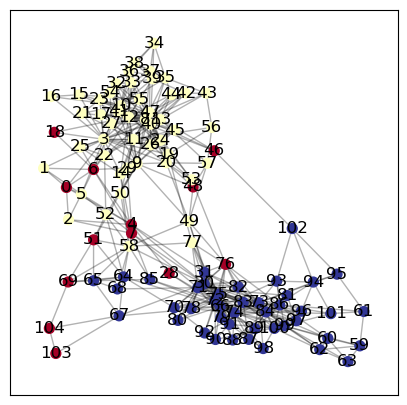

In [1812]:
G = nx.read_gml(os.path.join(os.getcwd(), 'data', 'football', 'football.gml'), label='id')
classes = readCommunityClasses(os.path.join(os.getcwd(), 'data', 'football', 'classLabelfootball.txt'))
print(max(classes))

plotNetwork(G, classes)

Max Q = 0.8563098708871303
{15: [15, 16, 10, 3, 55, 19, 12, 18, 6, 1, 0, 5, 4, 2, 7, 29, 14, 25, 22, 11, 17, 21, 13, 48, 57, 49, 20, 9, 24, 53, 40, 26, 45, 47, 41, 27, 8, 54, 23, 32, 33, 44, 43, 56, 42, 39, 35, 37, 38, 34, 36, 50], 59: [59, 63, 60, 62, 99, 84, 100, 101, 86, 61, 95, 94, 73, 96, 97, 66, 93, 89, 81, 88, 46, 102, 87, 98, 74, 83, 30, 79, 72, 91, 90, 75, 82, 76, 71, 70, 31, 78, 80, 77, 92, 28], 65: [65, 68, 64, 58, 69, 51, 52, 103, 104, 67, 85]}
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 59, 15, 59, 59, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 59, 15, 15, 15, 15, 65, 65, 15, 15, 15, 15, 15, 65, 59, 59, 59, 59, 59, 65, 65, 59, 65, 65, 65, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 65, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 65, 65]


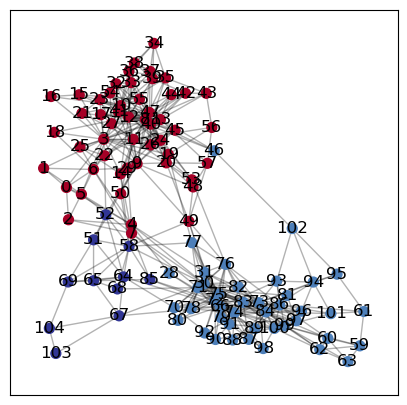

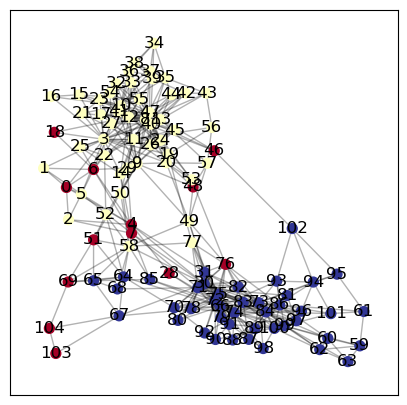

3


In [1813]:
dc = DetectingCommunities(G)
communities = dc.getCommunities()
print(communities)
plotNetwork(G, communities)
plotNetwork(G, classes)
print(len(np.unique(communities)))

In [1814]:
a = [1, 2, 3, 4]
list(filter(lambda x: x % 2 == 0, a))

[2, 4]